# Two-dimensional Polynomial Chaos

Here we will demonstrate a 2D PCE approach, using a simple scalar analytic test function $f(x)$, defined as:

\begin{align}
 f(x) = \exp\left[-\frac{1}{2}\left(x_1 - 2\right)^2 - \frac{1}{10}\left(x_2 - 1\right)^2\right] - (x_1 - 2)(x_2 - 1)^3
\end{align}

where $x_1\sim\mathcal{U}[1, 3]$ and $x_2\sim\mathcal{N}(1,1)$.

In [6]:
# uncomment to install any missing libraries
#!pip install numpy
#!pip install matplotlib
#!pip install chaospy
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 5.4 MB/s eta 0:00:004.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/wouter/py-env/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import chaospy as cp
import seaborn

In [8]:
def f(x1, x2):
    """
    Our analytic test function

    Parameters
    ----------
    x : float, or array of floats
        The input x.

    Returns
    -------
    f(x) : float, or array of floats
        The output f(x).

    """

    x1 = x1 + 2
    x2 = x2 + 1
    
    return np.exp(-0.5*(x1 - 2)**2 - 0.1*(x2 - 1)**2) - (x1 - 2)*(x2 - 1)**3

There are 2 sources of error in our PCE

* the truncation of the PCE expansion (regulated by $N$)
* the error in the quadrature approximation of $\mathbb{E}[f\phi_{\bf j}]$

In 1D, truncation of the PC expansion just amounts to selecting an integer $N$. For more than one uncertain parameter truncation involves selecting an multi index set $\Lambda$. Here each ${\bf i}\in\Lambda$ is given by ${\bf i}=(i_1,i_2,\cdots, i_D)$. Each $i_j$ selects a standard 1D orthogonal polynomial for the j-th input, and the $D$-dimensional basis function is simply the product of these 1D bases indexed by ${\bf i}$: $\Phi_{\bf i}=\phi_{i_1}(x_1)\cdots\phi_{i_d}(x_d)$.

One possible way to truncate is to select only those ${\bf i}$ for which $|{\bf i}|:=i_1 + \cdots + i_D \leq N$, where $N$ is again a user-specified integer, see the figure below for a 4D example.

![](./images/lexico.jpg)

In [9]:
def multi_indices(N, d, typ='simplex'):
    """
    Get a set of multi indices, either |i| <= N or max(i) <= N.

    Parameters
    ----------
    N : integer
        The cutoff value.
    d : integer
        The dimension of the multi indices.
    typ : string, optional
        The type of multi index set. If 'simplex' then |i| <= N is 
        returned. Otherwise max(i) <= N. The default is 'simplex'.

    Returns
    -------
    multi_idx : array
        The multi index set.

    """
        
    if typ != 'simplex':
        # max(i_1, i_2) <= N
        multi_idx = np.array(list(product(range(N+1), repeat=d)))
    else:
        # i_1 + i_2 <= N
        multi_idx = np.array(list(product(range(N+1), repeat=d)))
        idx = np.where(np.sum(multi_idx, axis=1) <= N)[0]
        multi_idx = multi_idx[idx]
    
    return multi_idx

In [10]:
def plot_multi_idx(ax, multi_idx, c='lightgray'):
    """
    Visualize a 2D or 3D multi index set.

    Parameters
    ----------
    ax : matplotlib axis
        The axis to plot on.
    multi_idx : array
        The array of multi indices.
    c : string, optional
        Color. The default is 'lightgray'.

    Returns
    -------
    None.

    """

    d = multi_idx[0].size

    if d == 2:

        for idx in multi_idx:
            idx0 = idx[0]; idx1 = idx[1]
            # plot midpoint
            ax.plot(idx0, idx1, 'x', color=c)
            # plot single square
            ax.plot([idx0 - 0.5, idx0 + 0.5], [idx1 - 0.5, idx1 - 0.5], color=c)
            ax.plot([idx0 + 0.5, idx0 + 0.5], [idx1 - 0.5, idx1 + 0.5], color=c)
            ax.plot([idx0 + 0.5, idx0 - 0.5], [idx1 + 0.5, idx1 + 0.5], color=c)
            ax.plot([idx0 - 0.5, idx0 - 0.5], [idx1 + 0.5, idx1 - 0.5], color=c)

    elif d == 3:

        # create 6 layers of 6 x 6 voxels
        voxels = np.zeros([6,6,6], dtype=bool)
        for idx in multi_idx:
            # set to True to display voxel
            voxels[idx[0], idx[1], idx[2]] = True

        #plot cubes
        ax.voxels(voxels, facecolors=c, edgecolor='k', alpha=0.8)     


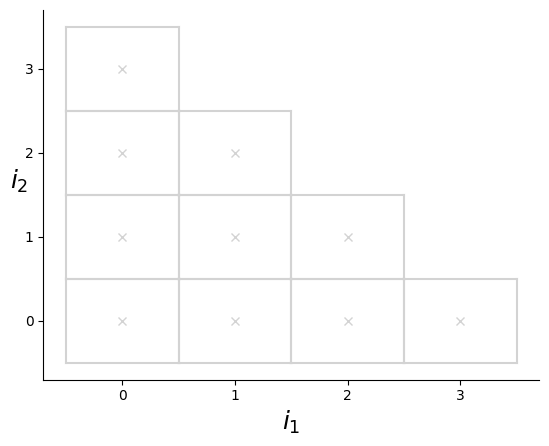

In [11]:
# multi index truncation
N = 3
# number of random inputs
d = 2
multi_idx = multi_indices(N, d)

# plot indices
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_xlabel(r'$i_1$', fontsize=18)
ax.set_ylabel(r'$i_2$', fontsize=18, rotation=0)
seaborn.despine(top=True)
plot_multi_idx(ax, multi_idx)

Unlike in the 1D PCE example (`1D_PCE_example.ipynb`), we will not rely on numpy to generate the quadrature rule (in which case we had to be careful not to select the "phycisist" version). Instead, we will use `chaospy` library to generate a rule direct for our assumed input distributions:

In [12]:
x1 = cp.Uniform(-1, 1)
x2 = cp.Normal()

Q = N

x1_k, w1_k = cp.generate_quadrature(Q, x1, rule="G")
x2_k, w2_k = cp.generate_quadrature(Q, x2, rule="G")

print(x1_k)
print(x2_k)
print(w1_k.sum())
print(w2_k.sum())

[[-0.86113631 -0.33998104  0.33998104  0.86113631]]
[[-2.33441422 -0.74196378  0.74196378  2.33441422]]
1.0000000000000004
1.0000000000000002


### Computing the PCE coefficients

Remember, the numerator and denominator of the PCE coefficients are given by:

\begin{align*}
 \mathbb{E}\left[f\Phi_{\bf i} \right] &= \int\int f(x_1, x_2)\; \phi_{i_1}(x_1)\phi_{i_2}(x_2)\; p(x_1)p(x_2)\;d x_1d x_2 \\\\
 &\approx \sum_k\sum_l f\left(x_{1,k},\; x_{2,l}\right)\; \phi_{i_1}\left(x_{1,k}\right)\phi_{i_2}\left(x_{2,l}\right)\; w_kw_l
\end{align*}

\begin{align*}
 \gamma_{\bf i}= \mathbb{E} \left[\Phi_{\bf i}\Phi_{\bf i} \right] &= \int\int \phi_{i_1}(x_1)\phi_{i_2}(x_2)\;\phi_{i_1}(x_1)\phi_{i_2}(x_2)\; p(x_1)p(x_2)\;d x_1d x_2 \\
&=
\int \phi_{i_1}(x_1)\phi_{i_1}(x_1)p(x_1)d x_1\int\phi_{i_2}(x_2)\phi_{i_2}(x_2)p(x_1)d x_2 \\
&=: \gamma_{i_1}\gamma_{i_2}
\end{align*}


In [13]:
def get_pce_coefs(N, x1, x2, d = 2):
    """
    Compute the PCE coefficients for a PCE expansion of N terms, using a
    Q-point Legendre-Gauss quadrature rule.

    Parameters
    ----------
    N : integer
        The number of PCE terms.

    Returns
    -------
    pce_coefs : array
        N PCE coefficients.
    gamma : array
        N normalization coefficients gamma_i
    n_samples : int
        The number of model evaluations.

    """

    # get the quad rule, correct for wrong weight
    x1_k, w1_k = cp.generate_quadrature(N, x1, rule='G')
    x1_k = x1_k[0]
    x2_k, w2_k = cp.generate_quadrature(N, x2, rule='G')
    x2_k = x2_k[0]

    multi_idx = multi_indices(N, d)
   
    phi1, gamma1 = cp.expansion.stieltjes(N, x1, normed=False, retall=True)
    phi2, gamma2 = cp.expansion.stieltjes(N, x2, normed=False, retall=True)

    pce_coefs = {}
    gamma = {}
    
    # compute the PCE coefficients
    for i in multi_idx:
        pce_coef_num_i = 0.0
        i_0 = i[0]; i_1 = i[1]

        # approximate with curbature
        for k1 in range(x1_k.size):
            for k2 in range(x2_k.size):
                x = x1_k[k1]; y = x2_k[k2]
                w1 = w1_k[k1]; w2 = w2_k[k2]
                pce_coef_num_i += f(x, y) * phi1[i_0](x) * phi2[i_1](y) * w1 * w2

        gamma[(i_0, i_1)] = gamma1[i_0] * gamma2[i_1]       
        pce_coefs[(i_0, i_1)] = pce_coef_num_i / gamma[(i_0, i_1)]

    n_samples = x1_k.size * x2_k.size
        
    return pce_coefs, gamma, n_samples


In [15]:
pce_coefs, gamma, _ = get_pce_coefs(4, x1, x2)
pce_coefs

{(0, 0): 0.7810801429018529,
 (0, 1): -2.7755575615628914e-17,
 (0, 2): -0.0652106881482057,
 (0, 3): -3.700743415417188e-17,
 (0, 4): 0.0031112885707245594,
 (1, 0): 1.1449174941446927e-16,
 (1, 1): -2.9999999999999973,
 (1, 2): 7.494005416219807e-16,
 (1, 3): -0.9999999999999991,
 (2, 0): -0.3709210190534325,
 (2, 1): 3.9031278209478165e-16,
 (2, 2): 0.030967391913518136,
 (3, 0): -2.580401170515501e-15,
 (3, 1): 1.7000290064572713e-14,
 (4, 0): 0.09515986881722172}

### Mean and variance

With the $\hat{f}_{\bf i}$ known, the mean and variance of $f$ (due to uncertainty in ${\bf x}$) are easily computed:

\begin{align*}
\boxed{
\mathbb{E}[f] = \hat{f}_{\bf 0}, \quad
\mathbb{V}\mathrm{ar}[f] = \sum_{\substack{{\bf i}\in\Lambda\\{\bf i}\neq{\bf 0}}}\hat{f}^2_{\bf i}\gamma_{\bf i}}
\end{align*}

Note that we must skip the $i=0$ index in the variance summation.

In [16]:
def get_mean_var(pce_coefs, gamma):
    """
    Compute the PCE mean and variance.

    Parameters
    ----------
    pce_coefs : array
        The PCE coefficients.
    gamma : array
        The normalization constants gamma_i.

    Returns
    -------
    mean : float
        The estimated mean of f(x).
    var : float
        The estimated variance of f(x).

    """

    mean = pce_coefs[(0,0)]
    var = 0.

    for i in pce_coefs.keys():
        if i != (0,0):
            var += np.sum(pce_coefs[i] ** 2 * gamma[i])

    return mean, var

In [17]:
get_mean_var(pce_coefs, gamma)

(0.7810801429018529, 5.021189789090943)

### MC vs PCE convergence

Below we compute the mean and standard deviation for an increasing number of PCE expansion terms. We also compute the same quantities using MC sampling, for a much larger range of code evaluations.

For MC sampling we repeat the experiment 50 times at each sampling size, as the computed mean and variance are random variables themselves due to sampling error. This is not the case for PCE. Once $p(x)$ has been chosen, the procedure is deterministic. This is because in PCE the sampling is not stochastic, the model is evaluated at the (non-random) points of the quadrature rule.

In [18]:
# PCE computation
# N = 1, 2, 3, ....
N_range = np.arange(1, 7)
mu_pce = np.zeros(N_range.size)
sigma_pce = np.zeros(N_range.size)
n_pce = np.zeros(N_range.size)

# compute moments for different N
for count, n in enumerate(N_range):
    pce_coefs, gamma, n_pce[count] = get_pce_coefs(n, x1, x2)
    mu_pce[count], sigma_pce[count] = get_mean_var(pce_coefs, gamma)

# var -> stddev
sigma_pce = np.sqrt(sigma_pce)

In [19]:
# compute the mean and variance via MC
n_mc = [10, 100, 1000, 10000, 100000, 1000000]

# MC moment estimates are random variables, repeat the calulations n_repeat times
n_repeat = 50

mu_mc = np.zeros([len(n_mc), n_repeat])
sigma_mc = np.zeros([len(n_mc), n_repeat])

for i, n in enumerate(n_mc):
    for j in range(n_repeat):
        samples = f(x1.sample(n), x2.sample(n))
        mu_mc[i, j] = np.mean(samples)
        sigma_mc[i, j] = np.std(samples)

Plot the PCE and MC results.

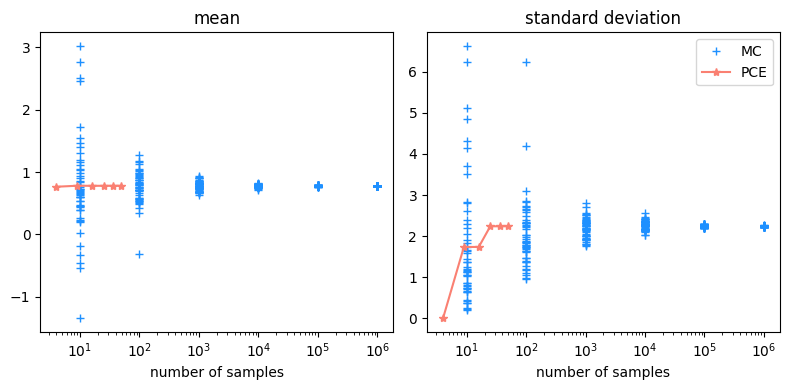

In [20]:
fig = plt.figure(figsize=[8, 4])
ax1 = fig.add_subplot(121, xscale='log', yscale='linear', title='mean', xlabel='number of samples')
ax2 = fig.add_subplot(122, xscale='log', yscale='linear', title='standard deviation', xlabel='number of samples')

ax1.plot(n_mc, mu_mc, '+', color='dodgerblue')
ax1.plot(n_pce, mu_pce * np.ones(len(n_pce)), '-*', color='salmon')

ax2.plot(n_mc, sigma_mc, '+', color='dodgerblue', label='MC')
ax2.plot(n_pce, sigma_pce, '-*', color='salmon', label='PCE')

# remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()

plt.show()

### Surrogate model

Note that the PCE expansion:

\begin{align*}
\boxed{
f({\bf x}) = \sum_{{\bf i}\in\Lambda}\hat{f}_{\bf i}\phi_{\bf i}({\bf x})}
\end{align*}

is a **surrogate model** of the computer code $f({\bf x})$. If $f({\bf x})$ is computationally expensive, it can take a long time to compute the $\hat{f}_{\bf i}$. Once this is done however, the expansion can be evaluated many times in a fraction of a second. It is a surrogate model, a fast approximation of the real computer model.


Below we compute the surrogate model:

/tmp/ipykernel_18752/2243456888.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  code[j, i] = f(x, y)
/tmp/ipykernel_18752/2243456888.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  surrogate[j, i] += pce_coefs[idx] * phi1[idx[0]](x) * phi1[idx[1]](y)


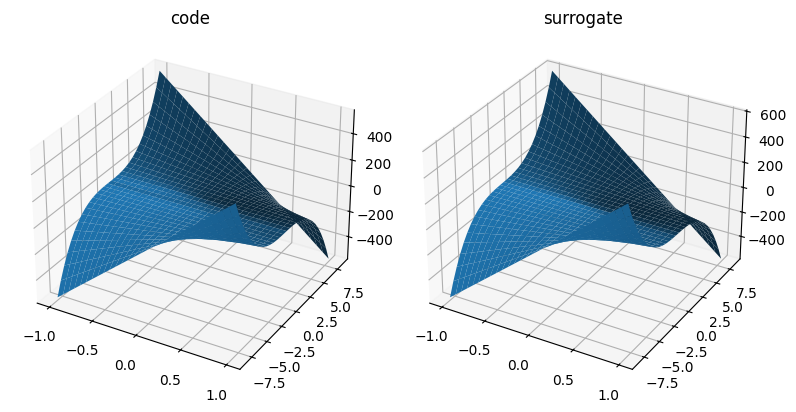

In [21]:
fig = plt.figure(figsize=[8, 4])
ax1 = fig.add_subplot(121, projection = '3d', title = 'code')
ax2 = fig.add_subplot(122, projection = '3d', title = 'surrogate')

# spatial grid
P = 30
xx1 = np.linspace(x1.lower, x1.upper, P)
xx2 = np.linspace(x2.lower, x2.upper, P)
X1, X2 = np.meshgrid(xx1, xx2)

# PCE coefficients
N = 4
pce_coefs, gamma, _ = get_pce_coefs(N, x1, x2)
N_p = len(pce_coefs)

# basis functions
phi1 = cp.expansion.stieltjes(N, x1)
phi2 = cp.expansion.stieltjes(N, x2)

code = np.zeros([P, P])
surrogate = np.zeros([P, P])

# clear (but prob slow) surrogate implementation
for i in range(P):
    for j in range(P):
        for idx in pce_coefs:
            x = xx1[i]; y = xx2[j]
            code[j, i] = f(x, y)
            surrogate[j, i] += pce_coefs[idx] * phi1[idx[0]](x) * phi1[idx[1]](y)

ax1.plot_surface(X1, X2, code)
ax2.plot_surface(X1, X2, surrogate)
plt.tight_layout()
